##Connecting the Kaggle API so the ASL data can be used here

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ak123000","key":"dedcfd10d760329a3d45f9acb3acbaed"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
100% 1.02G/1.03G [00:05<00:00, 211MB/s]
100% 1.03G/1.03G [00:05<00:00, 202MB/s]


##Unzipping the images

In [5]:
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

##Importing necessary libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

##Defining the dataset paths

In [7]:
#defining the dataset paths
train_data_dir = '/content/asl_alphabet_train/asl_alphabet_train'
test_data_dir = '/content/asl_alphabet_test/asl_alphabet_test'

##Data Augmentation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

#Data Pipeline

In [9]:
#loading data from train_dir
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

#loading dat for validation
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

#loading data from test_dir
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical'
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Found 0 images belonging to 0 classes.


##Data pre-check

In [10]:

print(train_generator.class_indices)
x_batch, y_batch = next(train_generator)
print(x_batch.shape)
print(y_batch.shape)


{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
(64, 64, 64, 3)
(64, 29)


#Model Building

In [11]:
model = Sequential()

# BLOCK1
model.add(Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(64,64,3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.30))

# BLOCK2
model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))

# BLOCK3
model.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.40))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(29, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 60, 60, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                        

#Model compilation

In [14]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

##Model Training

In [15]:
num_epochs = 20

history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = num_epochs
)

Epoch 1/20
1088/1088 [==============================] - 216s 196ms/step - loss: 3.4674 - accuracy: 0.3540 - val_loss: 2.7548 - val_accuracy: 0.4427
Epoch 2/20
1088/1088 [==============================] - 207s 190ms/step - loss: 1.6979 - accuracy: 0.7262 - val_loss: 2.6064 - val_accuracy: 0.5095
Epoch 3/20
1088/1088 [==============================] - 205s 188ms/step - loss: 1.2689 - accuracy: 0.8439 - val_loss: 1.6134 - val_accuracy: 0.7563
Epoch 4/20
1088/1088 [==============================] - 206s 190ms/step - loss: 1.1625 - accuracy: 0.8766 - val_loss: 1.8473 - val_accuracy: 0.6966
Epoch 5/20
1088/1088 [==============================] - 209s 192ms/step - loss: 1.1186 - accuracy: 0.8934 - val_loss: 1.3842 - val_accuracy: 0.8078
Epoch 6/20
1088/1088 [==============================] - 207s 191ms/step - loss: 1.0921 - accuracy: 0.9020 - val_loss: 1.6766 - val_accuracy: 0.7521
Epoch 7/20
1088/1088 [==============================] - 207s 190ms/step - loss: 1.0803 - accuracy: 0.9050 - val_

##Model Evaluation

In [16]:
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy}')

272/272 [==============================] - 32s 118ms/step - loss: 1.1711 - accuracy: 0.8660
Validation Loss: 1.171063780784607
Validation Accuracy: 0.8660345077514648


#Exploring the accuracies' and losses' w.r.t epochs

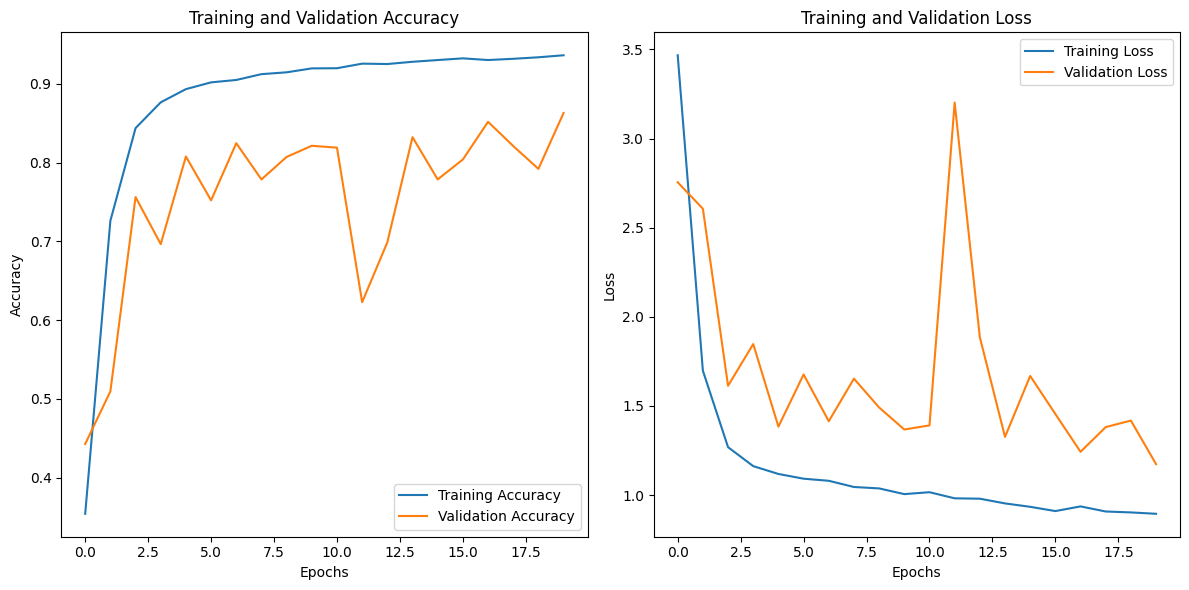

In [17]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Saving the model for future use

In [18]:
model.save('ASL_detection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
